참고 코드
*   텐서플로우 튜토리얼 (https://www.tensorflow.org/tutorials/)
*   머신 러닝 교과서 with 파이썬, 사이킷런, 텐서플로 개정 3판 (https://github.com/gilbutITbook/080223)
*   핸즈온 머신러닝 2판 (https://github.com/rickiepark/handson-ml2)
*   케라스 창시자에게 배우는 딥러닝 (https://github.com/rickiepark/deep-learning-with-python-notebooks/tree/tf2)


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import os, shutil, gzip

# [1] 순환 신경망의 구성 요소


## 1.1. 이론 복습

In [ ]:
#시퀀스 데이터 모델링
Image(url='https://git.io/JLdVm', width=700)

In [ ]:
#시퀀스 모델링 종류
Image(url='https://git.io/JLdVO', width=700)

In [ ]:
#순방향 신경망 v.s. 순환 신경망
Image(url='https://git.io/JLdV3', width=700)

In [ ]:
#RNN의 전체 구조
Image(url='https://git.io/JLdVs', width=700)

In [ ]:
#RNN의 가중치 계산
Image(url='https://git.io/JLdVC', width=700)

In [ ]:
#RNN의 가중치 계산 (두 가지 관점)
Image(url='https://git.io/JLdVW', width=700)

In [ ]:
#양방향(Bidirectional) RNN
Image(url='https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FkDuzx%2FbtqDzES5aes%2FcWsrbf3prQNM5VyzhxiXZ1%2Fimg.png')

## 1.2. Tensorflow Keras API로 기본 RNN 실습

In [ ]:
rnn_layer = tf.keras.layers.SimpleRNN(
    units=2, #뉴런의 개수 (은닉층(h)의 차원) 
    activation='tanh',
    use_bias=True, 
    return_sequences=True)

rnn_layer.build(input_shape=(None, None, 5)) # (시퀀스의 갯수, 시퀀스의 길이 (시간), 시퀀스 내 한 데이터의 차원)

w_xh, w_hh, b_h = rnn_layer.weights #w_ho는 생략

print('W_xh 크기:', w_xh.shape)
print('W_hh 크기:', w_hh.shape)
print('b_h 크기:', b_h.shape)

W_xh 크기: (5, 2)
W_hh 크기: (2, 2)
b_h 크기: (2,)


In [ ]:
x_seq = tf.convert_to_tensor( #하나의 시퀀스
    [[1.0]*5, #첫 번째 시간의 데이터 (5개의 특성으로 이루어짐)
     [2.0]*5, #두 번째 시간의 데이터 (5개의 특성으로 이루어짐)
     [3.0]*5],#세 번째 시간의 데이터 (5개의 특성으로 이루어짐)
    dtype=tf.float32)
print(x_seq)

tf.Tensor(
[[1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2.]
 [3. 3. 3. 3. 3.]], shape=(3, 5), dtype=float32)


In [ ]:
## SimepleRNN의 출력:
output = rnn_layer(tf.reshape(x_seq, shape=(1, 3, 5)))
print(output)

tf.Tensor(
[[[ 0.75851226 -0.9884687 ]
  [ 0.9346918  -0.9999941 ]
  [ 0.9874069  -1.        ]]], shape=(1, 3, 2), dtype=float32)


In [ ]:
## 수동으로 출력 계산해서 비교:
out_man = [] #출력 시퀀스 
for t in range(len(x_seq)):
    xt = tf.reshape(x_seq[t], (1, 5)) #현재 시간(t)의 입력 데이터
    print('타임 스텝 {} =>'.format(t))
    print('   입력           :', xt.numpy())
    
    ht = tf.matmul(xt, w_xh) + b_h #현재 시간(t)의 은닉(h) 데이터   
    print('   은닉           :', ht.numpy())
    
    if t>0:
        prev_h = out_man[t-1]
    else:
        prev_h = tf.zeros(shape=(ht.shape)) 
        
    ot = ht + tf.matmul(prev_h, w_hh) #현재 시간(t)의 출력 데이터 (활성화 적용 전)
    ot = tf.math.tanh(ot) #출력 데이터 활성화 적용 후
    out_man.append(ot) #출력 시퀀스 저장
    
    print('   출력 (수동)     :', ot.numpy())
    print('   SimpleRNN 출력 :'.format(t), output[0][t].numpy())
    print()

타임 스텝 0 =>
   입력           : [[1. 1. 1. 1. 1.]]
   은닉           : [[ 0.99270225 -2.575027  ]]
   출력 (수동)     : [[ 0.75851226 -0.9884687 ]]
   SimpleRNN 출력 : [ 0.75851226 -0.9884687 ]

타임 스텝 1 =>
   입력           : [[2. 2. 2. 2. 2.]]
   은닉           : [[ 1.9854045 -5.150054 ]]
   출력 (수동)     : [[ 0.9346918 -0.9999941]]
   SimpleRNN 출력 : [ 0.9346918 -0.9999941]

타임 스텝 2 =>
   입력           : [[3. 3. 3. 3. 3.]]
   은닉           : [[ 2.978107  -7.7250805]]
   출력 (수동)     : [[ 0.9874069 -1.       ]]
   SimpleRNN 출력 : [ 0.9874069 -1.       ]



## 1.3. 경사소실/폭발 문제와 LSTM

In [ ]:
Image(url='https://git.io/JLdV4', width=700)

In [ ]:
Image(url='https://git.io/JLdVR', width=700)

### TF Keras로 RNN 모델 만들기

* **케라스 RNN 층:**
  * `tf.keras.layers.SimpleRNN(units, return_sequences=False)`
  * `tf.keras.layers.LSTM(..)`
  * `tf.keras.layers.GRU(..)`
  * `tf.keras.layers.Bidirectional()`
 
* **`return_sequenes=?` 결정하기**
  * 다층 RNN이면 마지막 층을 제외하고 모든 RNN 층을 `return_sequenes=True`로 지정합니다
  * 마지막 RNN 층은 문제의 종류에 따라 결정됩니다:
     * 다대다: -> `return_sequences=True`
     * 다대일: -> `return_sequenes=False`

In [ ]:
# SimpleRNN 
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(1000, 32))
model.add(tf.keras.layers.SimpleRNN(32, return_sequences=True))
model.add(tf.keras.layers.SimpleRNN(32))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 36,193
Trainable params: 36,193
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# LSTM
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(1000, 32))
model.add(tf.keras.layers.LSTM(32, return_sequences=True))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 48,673
Trainable params: 48,673
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# GRU
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(1000, 32))
model.add(tf.keras.layers.GRU(32, return_sequences=True))
model.add(tf.keras.layers.GRU(32))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
gru (GRU)                    (None, None, 32)          6336      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 44,705
Trainable params: 44,705
Non-trainable params: 0
_________________________________________________________________


# [2] 간단한 RNN으로 타임시리즈 예측하기 


## 2.1. 타임시리즈 데이터 생성하기

In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

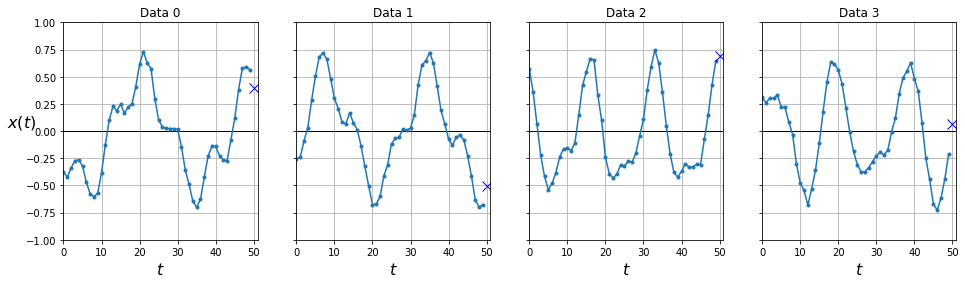

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(16, 4))
for col in range(4):
    plt.sca(axes[col])
    plt.title('Data '+str(col))
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

## 2.2. 베이스라인

### 2.2.1. 가장 직전값으로 예측

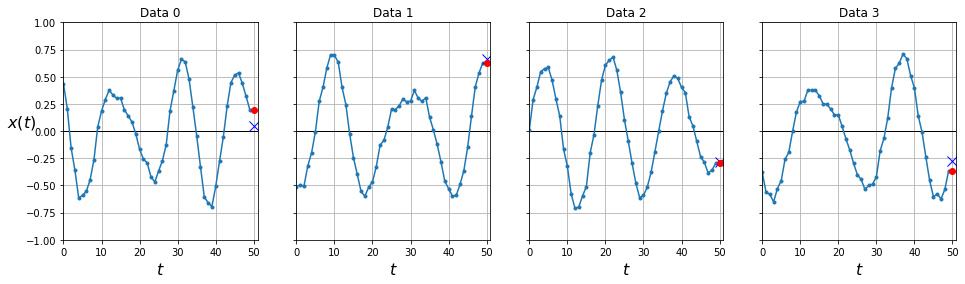

In [ ]:
y_pred = X_test[:, -1]

fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(16, 4))
for col in range(4):
    plt.sca(axes[col])
    plt.title('Data '+str(col))
    plot_series(X_test[col, :, 0], y_test[col, 0], y_pred[col, 0], y_label=("$x(t)$" if col==0 else None))

plt.show()

In [ ]:
MSE = np.mean(tf.keras.losses.mean_squared_error(y_test, y_pred))
print("평균제곱오차: ", MSE)

평균제곱오차:  0.021811275


### 2.2.1. 선형 모델로 예측

In [ ]:
#feature가 50개인 데이터 x가 7000개 있는 상황(X_train)에서 y(51번째 feature)를 예측하는 것임 (데이터가 50개가 있는 상황 아님)
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[50, 1]),
    tf.keras.layers.Dense(1, activation = 'linear')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
model.save("linear_model.h5")

Epoch 1/20
219/219 [==============================] - 3s 2ms/step - loss: 0.0949 - val_loss: 0.0302
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0160
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0108
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0084
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0047

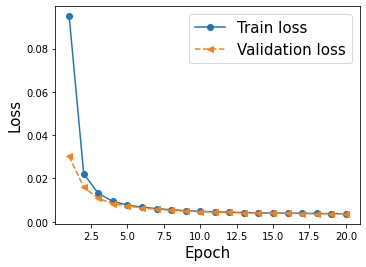

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
plt.show()

In [ ]:
MSE = model.evaluate(X_test, y_test)
print("평균제곱오차: ", MSE)

32/32 [==============================] - 0s 2ms/step - loss: 0.0036
평균제곱오차:  0.0035853246226906776


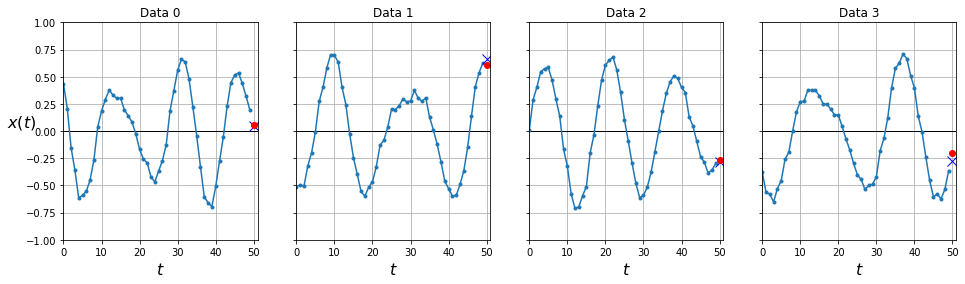

In [ ]:
y_pred = model.predict(X_test)

fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(16, 4))
for col in range(4):
    plt.sca(axes[col])
    plt.title('Data '+str(col))
    plot_series(X_test[col, :, 0], y_test[col, 0], y_pred[col, 0], y_label=("$x(t)$" if col==0 else None))

plt.show()

## 2.3. 얕은 RNN으로 예측

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(units = 1, #output의 차원
                              activation='tanh', 
                              input_shape=[50, 1])
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0655 - val_loss: 0.0557
Epoch 2/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0448 - val_loss: 0.0381
Epoch 3/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0302 - val_loss: 0.0254
Epoch 4/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0204 - val_loss: 0.0176
Epoch 5/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0151 - val_loss: 0.0136
Epoch 6/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0128 - val_loss: 0.0121
Epoch 7/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0120 - val_loss: 0.0116
Epoch 8/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0118 - val_loss: 0.0114
Epoch 9/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0117 - val_loss: 0.0113
Epoch 10/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0116 - val_lo

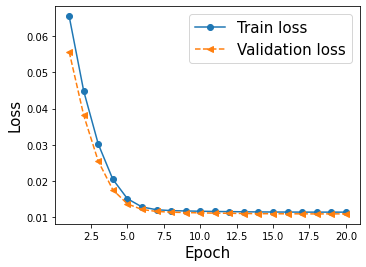

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
plt.show()

In [ ]:
MSE = model.evaluate(X_test, y_test)
print("평균제곱오차: ", MSE)

32/32 [==============================] - 0s 4ms/step - loss: 0.0113
평균제곱오차:  0.01127998623996973


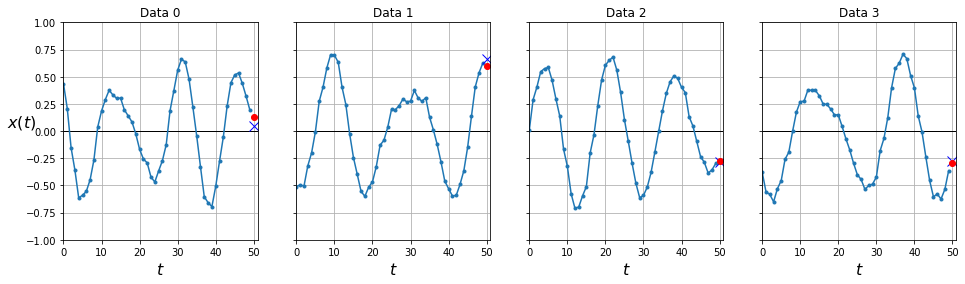

In [ ]:
y_pred = model.predict(X_test)

fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(16, 4))
for col in range(4):
    plt.sca(axes[col])
    plt.title('Data '+str(col))
    plot_series(X_test[col, :, 0], y_test[col, 0], y_pred[col, 0], y_label=("$x(t)$" if col==0 else None))

plt.show()

## 2.4. 깊은 RNN으로 예측

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(20,
                              return_sequences=True, #output을 시퀀스의 마지막 값이 아닌 전체 시퀀스로 반환
                              input_shape=[50, 1]),
    tf.keras.layers.SimpleRNN(20, return_sequences=True),
    tf.keras.layers.SimpleRNN(1)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 50, 20)            440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 50, 20)            820       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
model.save('deepRNN1.h5')

Epoch 1/20
219/219 [==============================] - 25s 106ms/step - loss: 0.0382 - val_loss: 0.0083
Epoch 2/20
219/219 [==============================] - 23s 105ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 3/20
219/219 [==============================] - 23s 104ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 22s 102ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 5/20
219/219 [==============================] - 23s 105ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 23s 105ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 7/20
219/219 [==============================] - 23s 104ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 23s 104ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 9/20
219/219 [==============================] - 23s 105ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 10/20
219/219 [==============================] - 23s 104ms/step - l

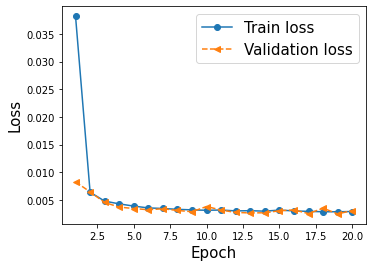

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
plt.show()

In [ ]:
MSE = model.evaluate(X_test, y_test)
print("평균제곱오차: ", MSE)

32/32 [==============================] - 0s 11ms/step - loss: 0.0030
평균제곱오차:  0.0030139500740915537


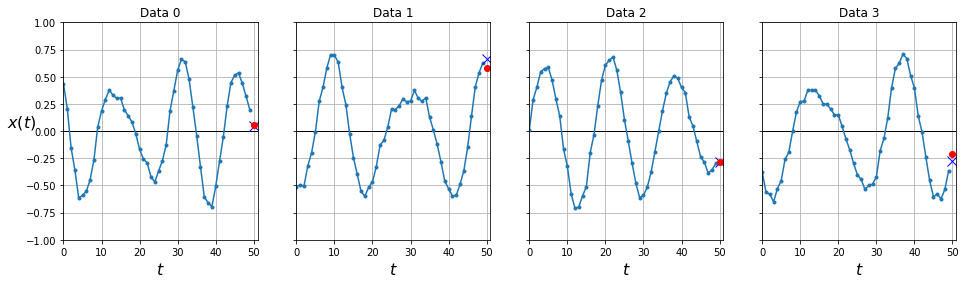

In [ ]:
y_pred = model.predict(X_test)

fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(16, 4))
for col in range(4):
    plt.sca(axes[col])
    plt.title('Data '+str(col))
    plot_series(X_test[col, :, 0], y_test[col, 0], y_pred[col, 0], y_label=("$x(t)$" if col==0 else None))

plt.show()

두번째 RNN레이어가 시퀀스의 마지막 값만 출력하도록 변경 (return_sequences = False)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[50, 1]),
    tf.keras.layers.SimpleRNN(20),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 50, 20)            440       
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
model.save('deepRNN2.h5')

Epoch 1/20
219/219 [==============================] - 17s 71ms/step - loss: 0.0489 - val_loss: 0.0063
Epoch 2/20
219/219 [==============================] - 15s 70ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 3/20
219/219 [==============================] - 15s 69ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 4/20
219/219 [==============================] - 15s 69ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 5/20
219/219 [==============================] - 15s 69ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 6/20
219/219 [==============================] - 16s 71ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 7/20
219/219 [==============================] - 15s 69ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 8/20
219/219 [==============================] - 15s 69ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 9/20
219/219 [==============================] - 15s 69ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 15s 69ms/step - loss: 0.003

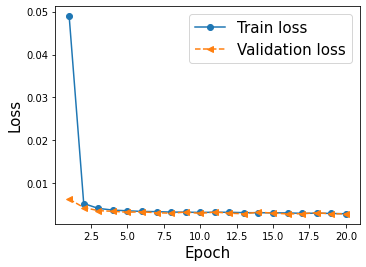

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
plt.show()

In [ ]:
MSE = model.evaluate(X_test, y_test)
print("평균제곱오차: ", MSE)

32/32 [==============================] - 0s 8ms/step - loss: 0.0028
평균제곱오차:  0.002799544483423233


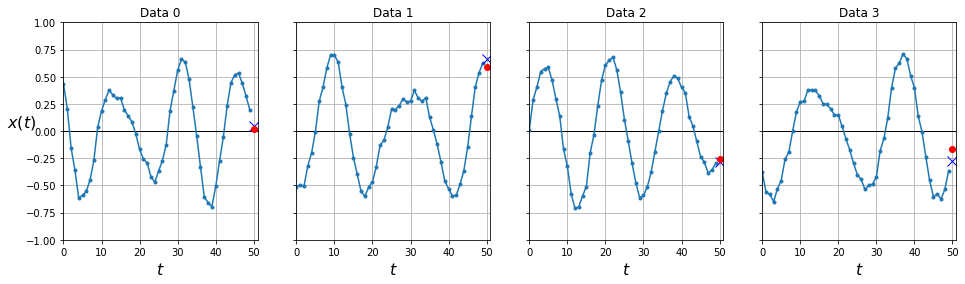

In [ ]:
y_pred = model.predict(X_test)

fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(16, 4))
for col in range(4):
    plt.sca(axes[col])
    plt.title('Data '+str(col))
    plot_series(X_test[col, :, 0], y_test[col, 0], y_pred[col, 0], y_label=("$x(t)$" if col==0 else None))

plt.show()

## 2.5. 깊은 LSTM으로 예측 

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(20, return_sequences=True, input_shape=[50, 1]),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(1)
])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 50, 20)            1760      
_________________________________________________________________
lstm_22 (LSTM)               (None, 50, 20)            3280      
_________________________________________________________________
lstm_23 (LSTM)               (None, 1)                 88        
Total params: 5,128
Trainable params: 5,128
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
model.save('deepLSTM.h5')

Epoch 1/20
219/219 [==============================] - 10s 13ms/step - loss: 0.0550 - val_loss: 0.0293
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0237 - val_loss: 0.0176
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0178 - val_loss: 0.0168
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0164 - val_loss: 0.0180
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0147 - val_loss: 0.0137
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0126 - val_loss: 0.0124
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0100 - val_loss: 0.0082
Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0081 - val_loss: 0.0069
Epoch 9/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0064 - val_loss: 0.0048
Epoch 10/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0045 - val_loss: 0.0

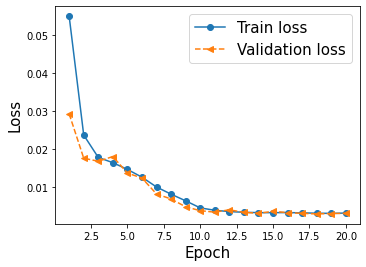

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
plt.show()

In [ ]:
MSE = model.evaluate(X_test, y_test)
print("평균제곱오차: ", MSE)

32/32 [==============================] - 0s 5ms/step - loss: 0.0034
평균제곱오차:  0.0034142984077334404


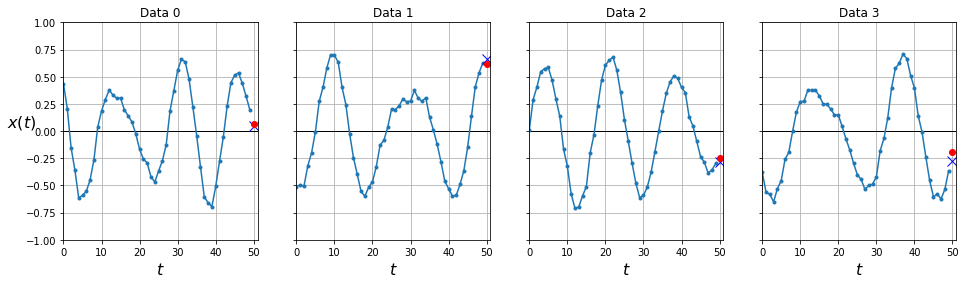

In [ ]:
y_pred = model.predict(X_test)

fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(16, 4))
for col in range(4):
    plt.sca(axes[col])
    plt.title('Data '+str(col))
    plot_series(X_test[col, :, 0], y_test[col, 0], y_pred[col, 0], y_label=("$x(t)$" if col==0 else None))

plt.show()

## 2.6. 깊은 GRU로 예측

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(20, return_sequences=True, input_shape=[50, 1]),
    tf.keras.layers.GRU(20, return_sequences=True),
    tf.keras.layers.GRU(1)
])

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50, 20)            1380      
_________________________________________________________________
gru_1 (GRU)                  (None, 50, 20)            2520      
_________________________________________________________________
gru_2 (GRU)                  (None, 1)                 69        
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
model.save('deepGRU.h5')

Epoch 1/20
219/219 [==============================] - 6s 12ms/step - loss: 0.0517 - val_loss: 0.0265
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0146 - val_loss: 0.0057
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0040 - val_loss: 0.0043
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 8/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 9/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0037 - val_loss: 0.003

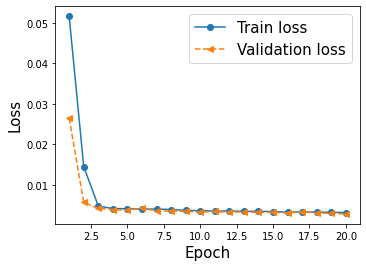

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
plt.show()

In [ ]:
MSE = model.evaluate(X_test, y_test)
print("평균제곱오차: ", MSE)

32/32 [==============================] - 0s 5ms/step - loss: 0.0030
평균제곱오차:  0.0030273664742708206


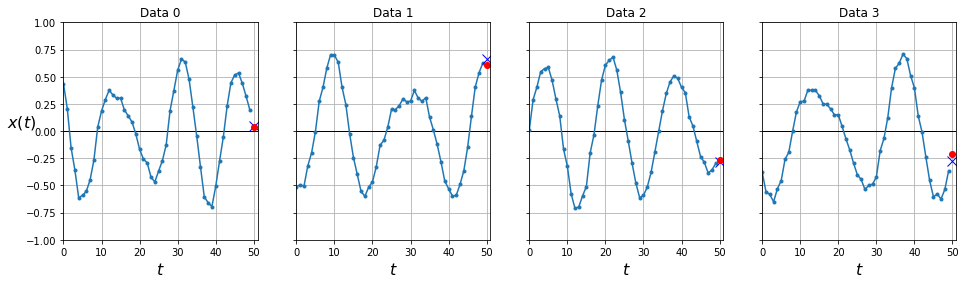

In [ ]:
y_pred = model.predict(X_test)

fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(16, 4))
for col in range(4):
    plt.sca(axes[col])
    plt.title('Data '+str(col))
    plot_series(X_test[col, :, 0], y_test[col, 0], y_pred[col, 0], y_label=("$x(t)$" if col==0 else None))

plt.show()

## 2.7. 복수 개의 다음 데이터 시퀀스 예측하기

### 2.7.1. 데이터 생성

In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10) #n_steps (50) 보다 10개 더 생성
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:]

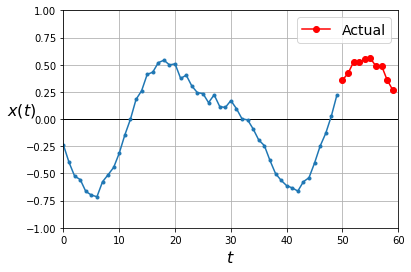

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    if Y_pred is not None:
      plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_test, Y_test, None)
plt.show()

### 2.7.2. 나이브 모델(직전값) 실험

In [ ]:
Y_pred = np.repeat(X_test[:, -1],10,axis=1)[...,np.newaxis]

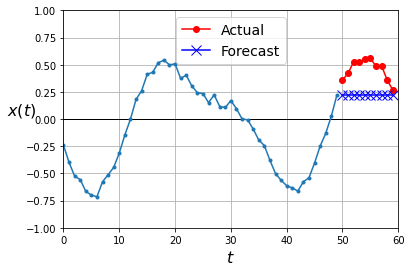

In [ ]:
plot_multiple_forecasts(X_test, Y_test, Y_pred)
plt.show()

In [ ]:
MSE = np.mean(tf.keras.metrics.mean_squared_error(Y_test, Y_pred))
print("평균제곱오차: ", MSE)

평균제곱오차:  0.26447314


### 2.7.3. 선형 모델 실험

In [ ]:
model = tf.keras.models.load_model('linear_model.h5')

#직전 n_steps(50)개 값으로 다음 값 예측 (1 ~ t => t+1, 2 ~ t+1 => t+2, ...)
X = X_test
for step_ahead in range(10): 
    y_pred_one = model.predict(X[:,step_ahead:])[:, np.newaxis]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

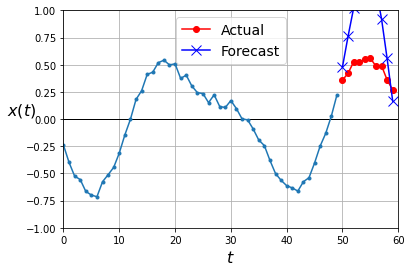

In [ ]:
plot_multiple_forecasts(X_test, Y_test, Y_pred)
plt.show()

In [ ]:
MSE = np.mean(tf.keras.metrics.mean_squared_error(Y_test, Y_pred))
print("평균제곱오차: ", MSE)

평균제곱오차:  0.056560352


### 2.7.4. 깊은 RNN 실험

In [ ]:
model = tf.keras.models.load_model('deepRNN2.h5')

#직전 n_steps(50)개 값으로 다음 값 예측 (1 ~ t => t+1, 2 ~ t+1 => t+2, ...)
X = X_test
for step_ahead in range(10):
    y_pred_one = model.predict(X[:,step_ahead:])[:, np.newaxis]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

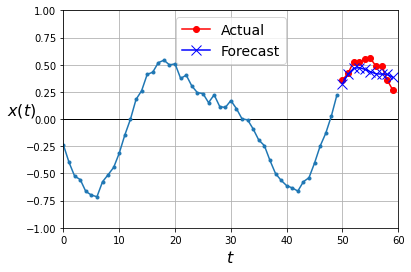

In [ ]:
plot_multiple_forecasts(X_test, Y_test, Y_pred)
plt.show()

In [ ]:
MSE = np.mean(tf.keras.metrics.mean_squared_error(Y_test, Y_pred))
print("평균제곱오차: ", MSE)

평균제곱오차:  0.023571014


### 2.7.5. 시퀀스 한번에 예측 모델 (최종 Dense)

In [ ]:
# 1~t 시퀀스로 t+1~t+10 예측
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[50, 1]),
    tf.keras.layers.SimpleRNN(20),
    tf.keras.layers.Dense(10) #다음 10개 값
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 17ms/step - loss: 0.0571 - val_loss: 0.0267
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0235 - val_loss: 0.0194
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0164 - val_loss: 0.0151
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0144 - val_loss: 0.0145
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0137 - val_loss: 0.0131
Epoch 6/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0120 - val_loss: 0.0107
Epoch 7/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0122 - val_loss: 0.0129
Epoch 8/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0115 - val_loss: 0.0125
Epoch 9/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0112 - val_loss: 0.0131
Epoch 10/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0107 - val_lo

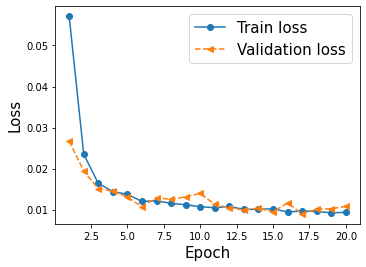

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
plt.show()

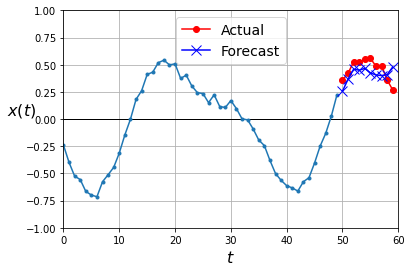

In [ ]:
Y_pred = model.predict(X_test)[:,:,np.newaxis]
plot_multiple_forecasts(X_test, Y_test, Y_pred)
plt.show()

In [ ]:
MSE = np.mean(tf.keras.metrics.mean_squared_error(Y_test, Y_pred))
print("평균제곱오차: ", MSE)

평균제곱오차:  0.010692225


### 2.7.6. 시퀀스 한번에 예측 모델 (최종 RNN)

In [ ]:
# 1~t 시퀀스로 t+1~t+10 예측
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[50, 1]),
    tf.keras.layers.SimpleRNN(20, return_sequences=True),
    tf.keras.layers.SimpleRNN(10)
])
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_63 (SimpleRNN)    (None, 50, 20)            440       
_________________________________________________________________
simple_rnn_64 (SimpleRNN)    (None, 50, 20)            820       
_________________________________________________________________
simple_rnn_65 (SimpleRNN)    (None, 10)                310       
Total params: 1,570
Trainable params: 1,570
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 25ms/step - loss: 0.0933 - val_loss: 0.0460
Epoch 2/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0395 - val_loss: 0.0325
Epoch 3/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0290 - val_loss: 0.0234
Epoch 4/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0227 - val_loss: 0.0196
Epoch 5/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0201 - val_loss: 0.0206
Epoch 6/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0179 - val_loss: 0.0180
Epoch 7/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0164 - val_loss: 0.0175
Epoch 8/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0151 - val_loss: 0.0150
Epoch 9/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0145 - val_loss: 0.0149
Epoch 10/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0139 - val_lo

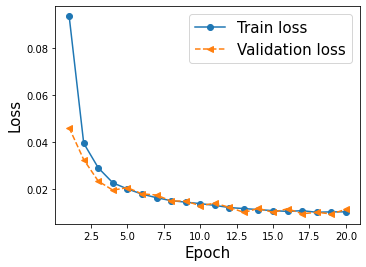

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
plt.show()

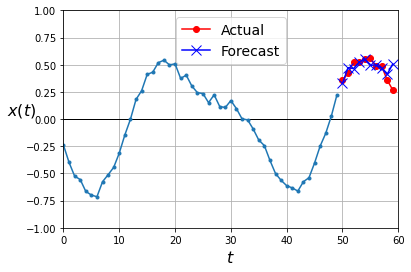

In [ ]:
Y_pred = model.predict(X_test)[:,:,np.newaxis]
plot_multiple_forecasts(X_test, Y_test, Y_pred)
plt.show()

In [ ]:
MSE = np.mean(tf.keras.metrics.mean_squared_error(Y_test, Y_pred))
print("평균제곱오차: ", MSE)

평균제곱오차:  0.011424036


# [3] 응용1 - IMDb 영화 리뷰 감성 분석

## 3.1. 영화 리뷰 데이터 준비

In [5]:
!mkdir ../ch08
!wget https://github.com/rickiepark/python-machine-learning-book-3rd-edition/raw/master/ch08/movie_data.csv.gz -O ../ch08/movie_data.csv.gz
with gzip.open('../ch08/movie_data.csv.gz', 'rb') as f_in, open('movie_data.csv', 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

--2021-07-07 08:17:49--  https://github.com/rickiepark/python-machine-learning-book-3rd-edition/raw/master/ch08/movie_data.csv.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch08/movie_data.csv.gz [following]
--2021-07-07 08:17:49--  https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch08/movie_data.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26521894 (25M) [application/octet-stream]
Saving to: ‘../ch08/movie_data.csv.gz’

../ch08/movie_data. 100%[===================>]  25.29M  --.

In [6]:
df = pd.read_csv('movie_data.csv', encoding='utf-8')
print(df.shape)
df.head()

(50000, 2)


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [7]:
#긍정적인 리뷰
print('리뷰: ', df['review'][3])
print('감성: ', df['sentiment'][3])

리뷰:  hi for all the people who have seen this wonderful movie im sure thet you would have liked it as much as i. i love the songs once you have seen the show you can sing along as though you are part of the show singing and dancing . dancing and singing. the song ONE is an all time fave musical song too and the strutters at the end with the mirror its so oh you have to watch this one
감성:  1


In [8]:
#부정적인 리뷰
print('리뷰: ', df['review'][4])
print('감성: ', df['sentiment'][4])

리뷰:  I recently bought the DVD, forgetting just how much I hated the movie version of "A Chorus Line." Every change the director Attenborough made to the story failed.<br /><br />By making the Director-Cassie relationship so prominent, the entire ensemble-premise of the musical sails out the window.<br /><br />Some of the musical numbers are sped up and rushed. The show's hit song gets the entire meaning shattered when it is given to Cassie's character.<br /><br />The overall staging is very self-conscious.<br /><br />The only reason I give it a 2, is because a few of the great numbers are still able to be enjoyed despite the film's attempt to squeeze every bit of joy and spontaneity out of it.
감성:  0


In [10]:
# 테스트/훈련/검증 데이터 준비
target = df.pop('sentiment')

ds_raw = tf.data.Dataset.from_tensor_slices((df.values, target.values))
ds_raw = ds_raw.shuffle(50000, reshuffle_each_iteration=False)

ds_raw_test = ds_raw.take(10000)
ds_raw_train_valid = ds_raw.skip(30000)
ds_raw_train = ds_raw_train_valid.take(15000)
ds_raw_valid = ds_raw_train_valid.skip(15000)

KeyError: ignored

 * **Tokenizer와 Encoder**
   * `tfds.deprecated.text.Tokenizer`: https://www.tensorflow.org/datasets/api_docs/python/tfds/deprecated/text/Tokenizer
   * `tfds.deprecated.text.TokenTextEncoder`: https://www.tensorflow.org/datasets/api_docs/python/tfds/deprecated/text/TokenTextEncoder

## 3.2. 텍스트를 벡터 시퀀스로 인코딩

In [11]:
#텍스트 토크나이징 및 카운팅
from collections import Counter

tokenizer = tfds.deprecated.text.Tokenizer()
token_counts = Counter()

for example in ds_raw_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0]) #텍스트 토크나이징
    token_counts.update(tokens) #토큰 카운팅

print('어휘 사전 예시:', token_counts.most_common(10)) 
print('어휘 사전 크기:', len(token_counts))

어휘 사전 예시: [('the', 169455), ('a', 92482), ('and', 92145), ('of', 84545), ('to', 78422), ('is', 62777), ('br', 60276), ('in', 51735), ('I', 49366), ('it', 46178)]
어휘 사전 크기: 76867


In [12]:
# 고유 토큰을 정수로 인코딩하기
encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)

example_str = 'An example sentence to be encoded'
encoder.encode(example_str)

[330, 331, 19813, 29, 156, 44301]

In [13]:
# 텐서 텍스트 -> 벡터 시퀀스 인코딩 함수
def encode(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    encoded_text = encoded_text[-100:] #학습의 용이성을 위해 마지막 100단어만 추출
    return encoded_text, label

# 인코딩 함수를 텐서플로 연산으로 감싸기
def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label], 
                          Tout=(tf.int64, tf.int64))

In [14]:
#훈련/검증/테스트 데이터 인코딩
ds_train = ds_raw_train.map(encode_map_fn)
ds_valid = ds_raw_valid.map(encode_map_fn)
ds_test = ds_raw_test.map(encode_map_fn)

for example in ds_train.shuffle(1000).take(10):
    print('시퀀스 길이:', example[0].shape)

print(example)

시퀀스 길이: (100,)
시퀀스 길이: (100,)
시퀀스 길이: (100,)
시퀀스 길이: (100,)
시퀀스 길이: (100,)
시퀀스 길이: (100,)
시퀀스 길이: (100,)
시퀀스 길이: (100,)
시퀀스 길이: (100,)
시퀀스 길이: (100,)
(<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([   4,  238,    8,   80,  911,  172,  165,   32,   42,   28,   29,
        156,  443,  180, 2900,  239, 8181,  180,   21, 2370,    5,   32,
         42,   28,  132,  588,   29,  156,   21, 5660,  722,  654,   46,
         86,  345,  192,  134,  520,   86,   45,   86,  203,   80,   21,
       2063, 8182,  291,  523,  109,    4,   11, 1499,   71,  130,   15,
       1101,  574,   86,  326,   80, 1042,   46,  489,   11, 8183, 2692,
         29, 3818,  288,  815, 7312,  754,   86, 2316,  109,  180,  292,
         86,  238, 5371,   15,  292,   29, 3817, 2522,   32,    6, 7405,
         32,   69, 8184, 8185,   90,   76, 6599, 8186, 1825, 7995,  680,
        681])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [15]:
# 같은 차원을 가지는 64개의 배치 데이터로 만들기 (각 배치의 데이터의 최대 차원(여기서는 100)으로 통일하고, 남는 차원은 0으로 채움)
train_data = ds_train.padded_batch(
    64, padded_shapes=([-1],[]))

valid_data = ds_valid.padded_batch(
    64, padded_shapes=([-1],[]))

test_data = ds_test.padded_batch(
    64, padded_shapes=([-1],[]))

## 3.3. 문장 임베딩 층

In [17]:
Image(url='https://git.io/JLdV0', width=700)

In [18]:
embedding_model = tf.keras.layers.Embedding(
                      input_dim= len(token_counts)+2, #input_dim의 크기를 가지는 양의 정수를 (각 토큰의 인덱스를)
                      output_dim=3) #output_dim 의 크기를 가지는 벡터로 (다른 차원의 임베딩으로) 변환
                      
#token_counts 개수에 2를 더해주는 이유는 '0'(빈 값을 채워준 것) 과 'n+1'(어휘 사전에 없는 단어)를 위해

In [19]:
sample = np.array([1, 98, 5, 6, 67, 45])

print(embedding_model(sample))

tf.Tensor(
[[ 0.00308721 -0.02736981  0.00191755]
 [-0.03866489  0.02983246 -0.03488957]
 [ 0.03179817 -0.03958278  0.03738428]
 [ 0.04030437 -0.02300349  0.00352641]
 [ 0.04107865 -0.02316718  0.01819481]
 [-0.04335105 -0.02198265  0.02181908]], shape=(6, 3), dtype=float32)


## 3.4. RNN 모델 만들기 

In [18]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(len(token_counts)+2, 20))
model.add(tf.keras.layers.SimpleRNN(20, return_sequences=True))
model.add(tf.keras.layers.SimpleRNN(20))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 20)          1541620   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 20)          820       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,543,281
Trainable params: 1,543,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

history = model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=10)

Epoch 1/10
235/235 [==============================] - 27s 108ms/step - loss: 0.4933 - accuracy: 0.7681 - val_loss: 0.9790 - val_accuracy: 0.5478
Epoch 2/10
235/235 [==============================] - 25s 107ms/step - loss: 0.2258 - accuracy: 0.9202 - val_loss: 1.7656 - val_accuracy: 0.5530
Epoch 3/10
235/235 [==============================] - 25s 107ms/step - loss: 0.1555 - accuracy: 0.9480 - val_loss: 2.9756 - val_accuracy: 0.5416
Epoch 4/10
235/235 [==============================] - 25s 108ms/step - loss: 0.1346 - accuracy: 0.9575 - val_loss: 2.6362 - val_accuracy: 0.5510
Epoch 5/10
235/235 [==============================] - 25s 108ms/step - loss: 0.0940 - accuracy: 0.9675 - val_loss: 3.4486 - val_accuracy: 0.5496
Epoch 6/10
235/235 [==============================] - 25s 106ms/step - loss: 0.0545 - accuracy: 0.9864 - val_loss: 3.2585 - val_accuracy: 0.5520
Epoch 7/10
235/235 [==============================] - 25s 106ms/step - loss: 0.0508 - accuracy: 0.9891 - val_loss: 3.5976 - val_ac

In [19]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

NameError: ignored

In [ ]:
accuracy= model.evaluate(test_data)
print('테스트 정확도: {:.2f}%'.format(accuracy[1]*100))

157/157 [==============================] - 8s 51ms/step - loss: 4.0392 - accuracy: 0.5679
테스트 정확도: 56.79%


## 3.5. LSTM 모델 만들기

In [21]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(len(token_counts)+2, 20))
model.add(tf.keras.layers.LSTM(20, return_sequences=True))
model.add(tf.keras.layers.LSTM(20))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 20)          1537380   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,543,961
Trainable params: 1,543,961
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

history = model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=10)

Epoch 1/10
235/235 [==============================] - 26s 75ms/step - loss: 0.5132 - accuracy: 0.7229 - val_loss: 0.3843 - val_accuracy: 0.8278
Epoch 2/10
235/235 [==============================] - 17s 73ms/step - loss: 0.2197 - accuracy: 0.9184 - val_loss: 0.4264 - val_accuracy: 0.8352
Epoch 3/10
235/235 [==============================] - 17s 74ms/step - loss: 0.1044 - accuracy: 0.9691 - val_loss: 0.5853 - val_accuracy: 0.8112
Epoch 4/10
235/235 [==============================] - 17s 73ms/step - loss: 0.0840 - accuracy: 0.9739 - val_loss: 0.4860 - val_accuracy: 0.8250
Epoch 5/10
235/235 [==============================] - 17s 73ms/step - loss: 0.0615 - accuracy: 0.9815 - val_loss: 0.7606 - val_accuracy: 0.7836
Epoch 6/10
235/235 [==============================] - 17s 73ms/step - loss: 0.0413 - accuracy: 0.9884 - val_loss: 0.7971 - val_accuracy: 0.8136
Epoch 7/10
235/235 [==============================] - 17s 73ms/step - loss: 0.0366 - accuracy: 0.9891 - val_loss: 0.7594 - val_accuracy:

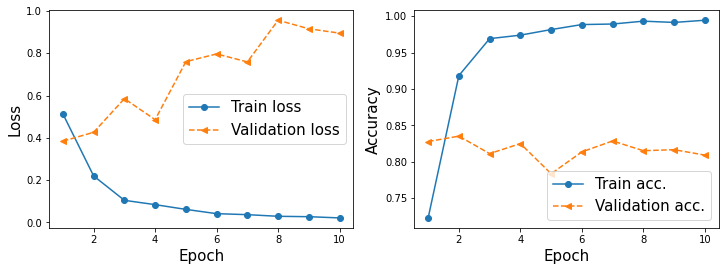

In [23]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [24]:
accuracy= model.evaluate(test_data)
print('테스트 정확도: {:.2f}%'.format(accuracy[1]*100))

157/157 [==============================] - 6s 38ms/step - loss: 0.9384 - accuracy: 0.7978
테스트 정확도: 79.78%


In [58]:
example = 'many people say among movie it was best movie in the wolrd and you must watch again!!! also, it is perpect movie'
predicted = model.predict([encoder.encode(example)])
print("긍정 리뷰 확률: ",np.round(predicted[0][0]*100,2),'%')

긍정 리뷰 확률:  99.72 %


## 3.6. GRU 모델 만들기

In [24]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(len(token_counts)+2, 20))
model.add(tf.keras.layers.GRU(20, return_sequences=True))
model.add(tf.keras.layers.GRU(20))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 20)          1541620   
_________________________________________________________________
gru (GRU)                    (None, None, 20)          2520      
_________________________________________________________________
gru_1 (GRU)                  (None, 20)                2520      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 1,546,681
Trainable params: 1,546,681
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'])

history = model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=10)

Epoch 1/10
235/235 [==============================] - 20s 72ms/step - loss: 0.7088 - accuracy: 0.6069 - val_loss: 0.5962 - val_accuracy: 0.6810
Epoch 2/10
235/235 [==============================] - 16s 70ms/step - loss: 0.5330 - accuracy: 0.7517 - val_loss: 0.6561 - val_accuracy: 0.7312
Epoch 3/10
235/235 [==============================] - 16s 70ms/step - loss: 0.4604 - accuracy: 0.8038 - val_loss: 0.9955 - val_accuracy: 0.6574
Epoch 4/10
235/235 [==============================] - 17s 71ms/step - loss: 0.3325 - accuracy: 0.8705 - val_loss: 0.9613 - val_accuracy: 0.7692
Epoch 5/10
235/235 [==============================] - 18s 74ms/step - loss: 0.2023 - accuracy: 0.9392 - val_loss: 0.9683 - val_accuracy: 0.8032
Epoch 6/10
235/235 [==============================] - 17s 73ms/step - loss: 0.1970 - accuracy: 0.9670 - val_loss: 1.2961 - val_accuracy: 0.7432
Epoch 7/10
235/235 [==============================] - 17s 72ms/step - loss: 0.2812 - accuracy: 0.9457 - val_loss: 0.6959 - val_accuracy:

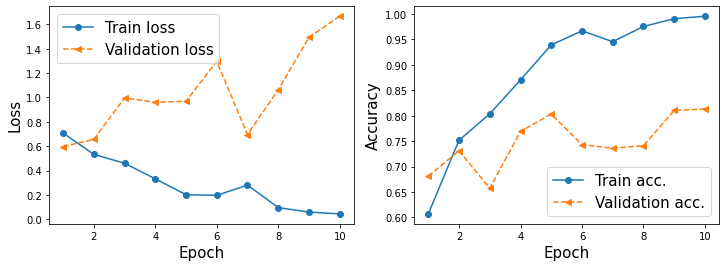

In [26]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [27]:
accuracy= model.evaluate(test_data)
print('테스트 정확도: {:.2f}%'.format(accuracy[1]*100))

157/157 [==============================] - 6s 37ms/step - loss: 1.6051 - accuracy: 0.8176
테스트 정확도: 81.76%


# [4] 응용2 - 문자 단위 예측 모델

In [ ]:
Image(url='https://git.io/JLdVE', width=700)

## 3.1. 데이터셋 전처리

In [ ]:
#영어 소설 The mysterious island

# 텍스트 다운로드
!wget https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch16/1268-0.txt

# 텍스트 읽고 전처리하기
with open('1268-0.txt', 'r', encoding='UTF8') as fp:
    text=fp.read()
    
start_indx = text.find('THE MYSTERIOUS ISLAND')
end_indx = text.find('End of the Project Gutenberg')
text = text[start_indx:end_indx]
char_set = set(text)

--2021-07-05 23:41:54--  https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch16/1268-0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1171600 (1.1M) [text/plain]
Saving to: ‘1268-0.txt’

1268-0.txt          100%[===================>]   1.12M  --.-KB/s    in 0.06s   

2021-07-05 23:41:55 (17.3 MB/s) - ‘1268-0.txt’ saved [1171600/1171600]



In [ ]:
#어린 왕자
# with open('young_prince'.txt', 'r', encoding='utf-8') as fp:
#     text=fp.read()
# char_set = set(text)

#한국 현대 문학 모음
# with open('contemp.txt', 'r', encoding='utf-8') as fp:
#     text=fp.read()
# char_set = set(text)

In [ ]:
text[:100]

'THE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced by Anthony Matonak, and Trevor Carlson\n\n\n\n\n\nTHE MYSTERIOUS IS'

In [ ]:
print('전체 길이:', len(text))
print('고유한 문자:', len(char_set))
print(char_set)

전체 길이: 1112350
고유한 문자: 80
{'?', '‘', ';', 'r', 'i', 'p', 'Q', '’', '/', 'o', 'G', 'w', '0', '5', 'T', 'P', 'K', ':', 'Y', 'J', 'B', '=', '-', 'E', 'a', 'z', '”', '1', 'F', 'V', '4', 'l', 'U', 'x', '2', 'I', 'u', 'Z', 'd', ',', '(', 'C', 'D', 'g', 'j', '9', 's', 'A', 'y', 'm', 'O', 'L', 'W', 'h', 'f', '3', 'H', 'N', '*', '8', 'q', 'n', 'M', '“', '&', 'b', 'e', 'S', '!', '7', 't', 'v', '.', '\n', 'c', ' ', '6', ')', 'k', 'R'}


In [ ]:
Image(url='https://git.io/JLdVz', width=700)

In [ ]:
chars_sorted = sorted(char_set)
char2int = {ch:i for i,ch in enumerate(chars_sorted)}
char_array = np.array(chars_sorted)

print(char2int)
print(char_array)

{'\n': 0, ' ': 1, '!': 2, '&': 3, '(': 4, ')': 5, '*': 6, ',': 7, '-': 8, '.': 9, '/': 10, '0': 11, '1': 12, '2': 13, '3': 14, '4': 15, '5': 16, '6': 17, '7': 18, '8': 19, '9': 20, ':': 21, ';': 22, '=': 23, '?': 24, 'A': 25, 'B': 26, 'C': 27, 'D': 28, 'E': 29, 'F': 30, 'G': 31, 'H': 32, 'I': 33, 'J': 34, 'K': 35, 'L': 36, 'M': 37, 'N': 38, 'O': 39, 'P': 40, 'Q': 41, 'R': 42, 'S': 43, 'T': 44, 'U': 45, 'V': 46, 'W': 47, 'Y': 48, 'Z': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, '‘': 76, '’': 77, '“': 78, '”': 79}
['\n' ' ' '!' '&' '(' ')' '*' ',' '-' '.' '/' '0' '1' '2' '3' '4' '5' '6'
 '7' '8' '9' ':' ';' '=' '?' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K'
 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'Y' 'Z' 'a' 'b' 'c' 'd'
 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u'

In [ ]:
char2int['a']

50

In [ ]:
char_array[[37, 40, 45]]

array(['M', 'P', 'U'], dtype='<U1')

In [ ]:
text_encoded = np.array(
    [char2int[ch] for ch in text],
    dtype=np.int32)

print('인코딩된 텍스트 크기: ', text_encoded.shape)

print(text[:15], '     == 인코딩 ==> ', text_encoded[:15])
print(text_encoded[15:21], ' == 디코딩 ==> ', ''.join(char_array[text_encoded[15:21]]))

인코딩된 텍스트 크기:  (1112350,)
THE MYSTERIOUS       == 인코딩 ==>  [44 32 29  1 37 48 43 44 29 42 33 39 45 43  1]
[33 43 36 25 38 28]  == 디코딩 ==>  ISLAND


## 3.2. 다음 문자 예측 훈련 데이터셋 생성

In [ ]:
Image(url='https://git.io/JLdVr', width=700)

In [ ]:
#text_encoded로 tf용 데이터셋 구성
ds_text_encoded = tf.data.Dataset.from_tensor_slices(text_encoded)

#1~40번째 문자로 2~41번째 문자 예측
seq_length = 40
chunk_size = seq_length + 1

#41개씩 배치로 읽어들임
ds_chunks = ds_text_encoded.batch(chunk_size, drop_remainder=True)

In [ ]:
# 입력 x 와 정답 y를 나누기 위한 함수를 정의
def split_input_target(chunk):
    input_seq = chunk[:-1]
    target_seq = chunk[1:]
    return input_seq, target_seq

ds_sequences = ds_chunks.map(split_input_target)

# 확인:
for example in ds_sequences.shuffle(10000).take(5):
    print('입력 (x):', repr(''.join(char_array[example[0].numpy()])))
    print('정답 (y):', repr(''.join(char_array[example[1].numpy()])))
    print()

입력 (x): 'heir fusiform conformation, being excell'
정답 (y): 'eir fusiform conformation, being excelle'

입력 (x): 'really beautiful!” said Gideon Spilett. '
정답 (y): 'eally beautiful!” said Gideon Spilett. “'

입력 (x): 'sin,\nwhose illuminating power increased '
정답 (y): 'in,\nwhose illuminating power increased s'

입력 (x): 'pregnated it with nitrate of potash, of '
정답 (y): 'regnated it with nitrate of potash, of w'

입력 (x): '\nAs to Pencroft, he had sailed over ever'
정답 (y): 'As to Pencroft, he had sailed over every'



In [ ]:
# 데이터셋 준비
BATCH_SIZE = 64
ds = ds_sequences.shuffle(10000).batch(BATCH_SIZE)

## 3.3. 모델 훈련하기

In [ ]:
charset_size = len(char_array)
embedding_dim = 256
rnn_units = 512

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(charset_size, embedding_dim),
    tf.keras.layers.LSTM(rnn_units, return_sequences=True),
    tf.keras.layers.LSTM(rnn_units, return_sequences=True),
    tf.keras.layers.Dense(charset_size)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         20480     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 512)         1574912   
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 512)         2099200   
_________________________________________________________________
dense_2 (Dense)              (None, None, 80)          41040     
Total params: 3,735,632
Trainable params: 3,735,632
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

model.fit(ds, epochs=30)

Epoch 1/30
424/424 [==============================] - 11s 19ms/step - loss: 1.5866
Epoch 2/30
424/424 [==============================] - 8s 19ms/step - loss: 1.2680
Epoch 3/30
424/424 [==============================] - 8s 19ms/step - loss: 1.1861
Epoch 4/30
424/424 [==============================] - 8s 19ms/step - loss: 1.1339
Epoch 5/30
424/424 [==============================] - 8s 19ms/step - loss: 1.0933
Epoch 6/30
424/424 [==============================] - 8s 19ms/step - loss: 1.0573
Epoch 7/30
424/424 [==============================] - 8s 19ms/step - loss: 1.0231
Epoch 8/30
424/424 [==============================] - 8s 19ms/step - loss: 0.9890
Epoch 9/30
424/424 [==============================] - 8s 19ms/step - loss: 0.9560
Epoch 10/30
424/424 [==============================] - 8s 19ms/step - loss: 0.9214
Epoch 11/30
424/424 [==============================] - 8s 19ms/step - loss: 0.8863
Epoch 12/30
424/424 [==============================] - 8s 19ms/step - loss: 0.8505
Epoch 13/30


## 3.4. 모델 테스트해보기

In [ ]:
starting_str = 'Hello my name is'
max_input_length = 40
max_gen_length = 20

encoded_input = [char2int[s] for s in starting_str]
encoded_input = tf.reshape(encoded_input, (1, -1))

generated_str = starting_str

for i in range(max_gen_length):
  logits = model(encoded_input)[0]

  new_char_indx = np.argmax(logits,axis=1)[-1]
  new_char = char_array[new_char_indx]
  generated_str += str(new_char)

  encoded_input = tf.reshape(np.append(encoded_input.numpy(), new_char_indx), (1, -1))
  encoded_input = encoded_input[:, -max_input_length:]

print(generated_str)

Hello my name is more than your duty


# 부록

### A -- 데이터셋을 만드는 다른 방법: tensorflow_datasets 사용하기

In [ ]:
imdb_bldr = tfds.builder('imdb_reviews')
print(imdb_bldr.info)

imdb_bldr.download_and_prepare()

datasets = imdb_bldr.as_dataset(shuffle_files=False)

datasets.keys()

In [ ]:
imdb_train = datasets['train']
imdb_train = datasets['test']

### B -- Tokenizer와 Encoder

 * `tfds.deprecated.text.Tokenizer`: https://www.tensorflow.org/datasets/api_docs/python/tfds/deprecated/text/Tokenizer
 * `tfds.deprecated.text.TokenTextEncoder`: https://www.tensorflow.org/datasets/api_docs/python/tfds/deprecated/text/TokenTextEncoder

In [ ]:
vocab_set = {'a', 'b', 'c', 'd'}
encoder = tfds.deprecated.text.TokenTextEncoder(vocab_set)
print(encoder)

print(encoder.encode(b'a b c d, , : .'))

print(encoder.encode(b'a b c d e f g h i z'))

### C -- 케라스로 텍스트 전처리하기

In [ ]:
TOP_K = 200
MAX_LEN = 10

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=TOP_K)

tokenizer.fit_on_texts(['this is an example', 'je suis en forme '])
sequences = tokenizer.texts_to_sequences(['this is an example', 'je suis en forme '])
print(sequences)

tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_LEN)

In [ ]:
TOP_K = 20000
MAX_LEN = 500

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=TOP_K)

tokenizer.fit_on_texts(
    [example['text'].numpy().decode('utf-8') 
     for example in imdb_train])

x_train = tokenizer.texts_to_sequences(
    [example['text'].numpy().decode('utf-8')
     for example in imdb_train])

print(len(x_train))


x_train_padded = tf.keras.preprocessing.sequence.pad_sequences(
    x_train, maxlen=MAX_LEN)

print(x_train_padded.shape)